#### 特征筛选方法

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from featexp import univariate_plotter
from featexp import get_trend_stats
from featexp import get_univariate_plots

#### 银行还款预测数据集

In [2]:
application_raw = pd.read_csv('demo/data/application_train.csv')

In [3]:
application_raw.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

              ...              FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
0             ...                             0                0   
1             ...                             0                0   
2             ...                             0                0   
3             ...                             0                0   
4             ...                             0                0   

  FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
0                0                0                        0.0   
1                0                0                        0.0   
2                0                0                        0.0   
3                0                0                        NaN   
4                0                0                        0.0   

  AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       NaN                         NaN   
4                       0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  
0                         1.0  
1                         0.0  
2                         0.0  
3                         NaN  
4                         0.0  

[5 rows x 122 columns]

In [4]:
nulls = pd.isnull(application_raw).sum()
nulls

SK_ID_CURR                         0
TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OWN_CAR_AGE                   202929
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
F

In [5]:
less_nulls = nulls[(nulls < 3075) & (nulls != 0)].index
less_nulls

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'CNT_FAM_MEMBERS',
       'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE'],
      dtype='object')

In [6]:
less_nulls_float = []
for i in range(len(less_nulls)):
    if application_raw[less_nulls[i]].dtype != 'O':
        less_nulls_float.append(less_nulls[i])
less_nulls_float

['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE']

In [7]:
application_raw[less_nulls_float] = application_raw[less_nulls_float].fillna(application_raw[less_nulls_float].mean())
application_raw.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

              ...              FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
0             ...                             0                0   
1             ...                             0                0   
2             ...                             0                0   
3             ...                             0                0   
4             ...                             0                0   

  FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
0                0                0                        0.0   
1                0                0                        0.0   
2                0                0                        0.0   
3                0                0                        NaN   
4                0                0                        0.0   

  AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       NaN                         NaN   
4                       0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  
0                         1.0  
1                         0.0  
2                         0.0  
3                         NaN  
4                         0.0  

[5 rows x 122 columns]

In [8]:
more_nulls = nulls[(nulls >= 3075)].index
more_nulls_float = []
for i in range(len(more_nulls)):
    if application_raw[more_nulls[i]].dtype != 'O':
        more_nulls_float.append(more_nulls[i])

In [9]:
application_raw[more_nulls_float] = application_raw[more_nulls_float].fillna(application_raw[more_nulls_float].min() - 100)

In [10]:
application_raw.drop(columns=['ORGANIZATION_TYPE'], axis=1, inplace=True)  # Try using later

In [11]:
all_cols = application_raw.columns
cat_cols = []
for col in all_cols:
    if application_raw[col].dtype == 'O':
        cat_cols.append(col)

In [12]:
cat_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [13]:
application = pd.get_dummies(application_raw, columns=cat_cols, dummy_na=True)

In [14]:
application.head()

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      100002       1             0          202500.0    406597.5   
1      100003       0             0          270000.0   1293502.5   
2      100004       0             0           67500.0    135000.0   
3      100006       0             0          135000.0    312682.5   
4      100007       0             0          121500.0    513000.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0      24700.5         351000.0                    0.018801       -9461   
1      35698.5        1129500.0                    0.003541      -16765   
2       6750.0         135000.0                    0.010032      -19046   
3      29686.5         297000.0                    0.008019      -19005   
4      21865.5         513000.0                    0.028663      -19932   

   DAYS_EMPLOYED           ...             WALLSMATERIAL_MODE_Mixed  \
0           -637           ...                                    0   
1          -1188           ...                                    0   
2           -225           ...                                    0   
3          -3039           ...                                    0   
4          -3038           ...                                    0   

   WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                              0                          0   
1                              0                          0   
2                              0                          0   
3                              0                          0   
4                              0                          0   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                         0                                1   
1                         0                                0   
2                         0                                0   
3                         0                                0   
4                         0                                0   

   WALLSMATERIAL_MODE_Wooden  WALLSMATERIAL_MODE_nan  EMERGENCYSTATE_MODE_No  \
0                          0                       0                       1   
1                          0                       0                       1   
2                          0                       1                       0   
3                          0                       1                       0   
4                          0                       1                       0   

   EMERGENCYSTATE_MODE_Yes  EMERGENCYSTATE_MODE_nan  
0                        0                        0  
1                        0                        0  
2                        0                        1  
3                        0                        1  
4                        0                        1  

[5 rows x 203 columns]

In [15]:
X = application.drop(['TARGET'], axis=1) # Contains ID

In [16]:
y = application['TARGET']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
train_users = X_train[['SK_ID_CURR']]
train_users['TARGET'] = y_train
test_users = X_test[['SK_ID_CURR']]
test_users['TARGET'] = y_test
train_users.reset_index(drop=True, inplace=True)
test_users.reset_index(drop=True, inplace=True)

e:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
e:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [24]:
train_users.head()

SK_ID_CURR  TARGET
0      436794       0
1      354174       0
2      376164       0
3      319651       0
4      137317       0

In [27]:
def get_nonull_dummy_data(application_train_raw, dummy_drop=['ORGANIZATION_TYPE']):
    # Idenifying float cols with less nulls and imputing with mean
    nulls = pd.isnull(application_train_raw).sum()
    less_nulls = nulls[(nulls < 3075) & (nulls != 0)].index
    less_nulls_float = []
    for i in range(len(less_nulls)):
        if application_train_raw[less_nulls[i]].dtype != 'O':
            less_nulls_float.append(less_nulls[i])

    application_train_raw[less_nulls_float] = application_train_raw[less_nulls_float].fillna(application_train_raw[less_nulls_float].mean())

    # Idenifying float cols with high nulls and creating null_flag column and imputing with min-10
    more_nulls = nulls[(nulls >= 3075)].index
    more_nulls_float = []
    for i in range(len(more_nulls)):
        if application_train_raw[more_nulls[i]].dtype != 'O':
            more_nulls_float.append(more_nulls[i])

    application_train_raw[more_nulls_float] = application_train_raw[more_nulls_float].fillna(application_train_raw[more_nulls_float].min() - 100)

    # Get dummies. Drop some columns for now
    application_train_raw.drop(columns=dummy_drop, axis=1, inplace=True)  # Try using later

    all_cols = application_train_raw.columns
    cat_cols = []
    for col in all_cols:
        if application_train_raw[col].dtype == 'O':
            cat_cols.append(col)

    application_train_raw = pd.get_dummies(application_train_raw, columns=cat_cols, dummy_na=True)

    return application_train_raw
def import_and_create_TEST_data():
    application_raw = pd.read_csv('demo/data/application_test.csv')
    application = get_nonull_dummy_data(application_raw, dummy_drop=['ORGANIZATION_TYPE'])

    X = application # Contains ID

    users = X[['SK_ID_CURR']]
    users.reset_index(drop=True, inplace=True)

    return(X, users)
X_TEST, TEST_users = import_and_create_TEST_data()

In [28]:
drop=['CODE_GENDER_XNA', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_FAMILY_STATUS_Unknown', 'SK_ID_CURR']
X_train = X_train.drop(drop, axis=1)
X_test = X_test.drop(drop, axis=1)

In [29]:
data_train = X_train.reset_index(drop=True)
data_train['target'] = y_train.reset_index(drop=True)
data_test = X_test.reset_index(drop=True)
data_test['target'] = y_test.reset_index(drop=True)

                                        Plots for CNT_CHILDREN                                        
                                           Train data plots                                           


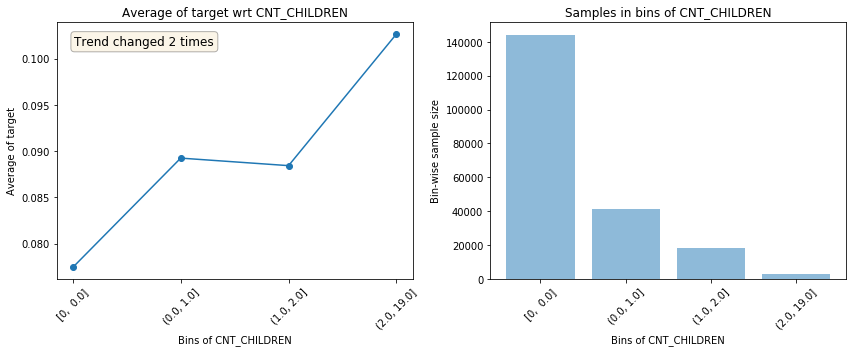

                                           Test data plots                                            


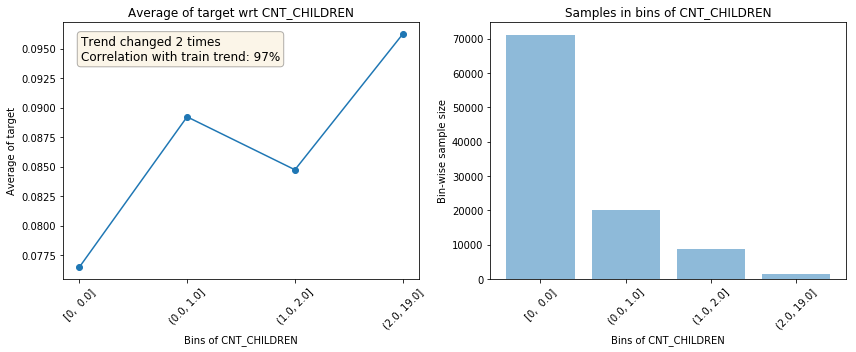

--------------------------------------------------------------------------------------------------------------


                                      Plots for AMT_INCOME_TOTAL                                      
                                           Train data plots                                           


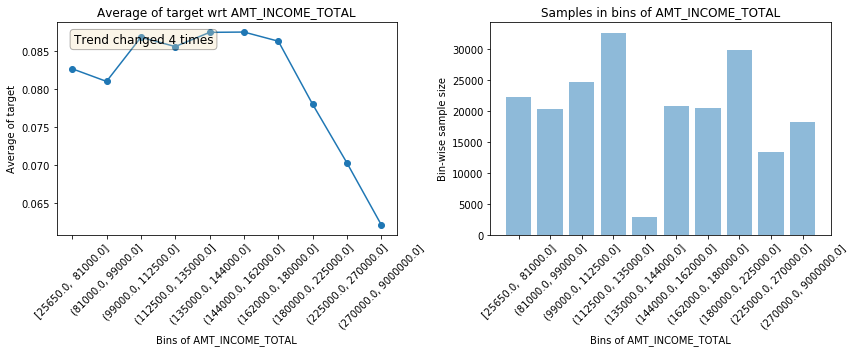

                                           Test data plots                                            


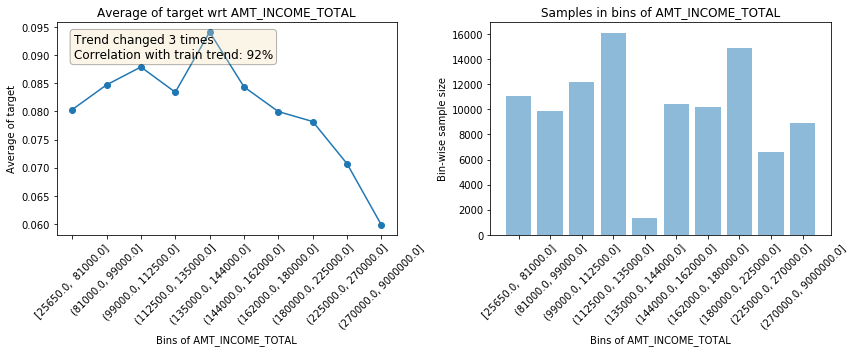

--------------------------------------------------------------------------------------------------------------


                                         Plots for AMT_CREDIT                                         
                                           Train data plots                                           


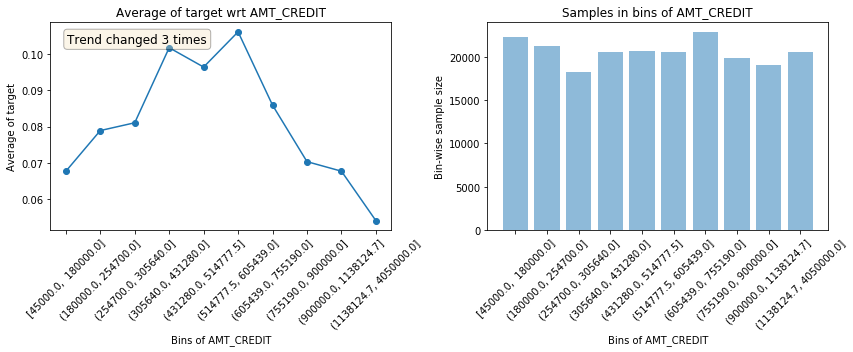

                                           Test data plots                                            


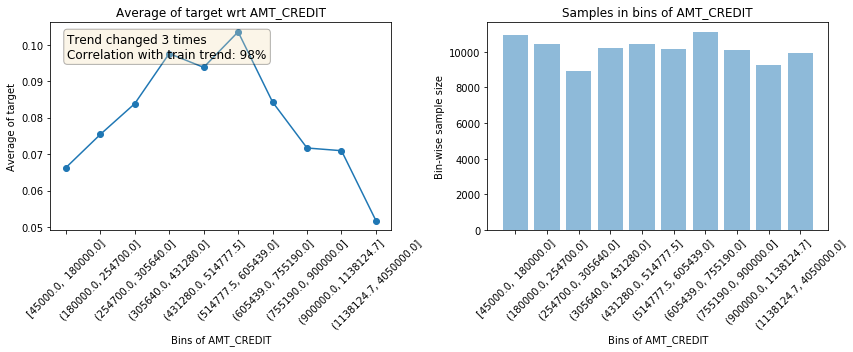

--------------------------------------------------------------------------------------------------------------


                                        Plots for AMT_ANNUITY                                         
                                           Train data plots                                           


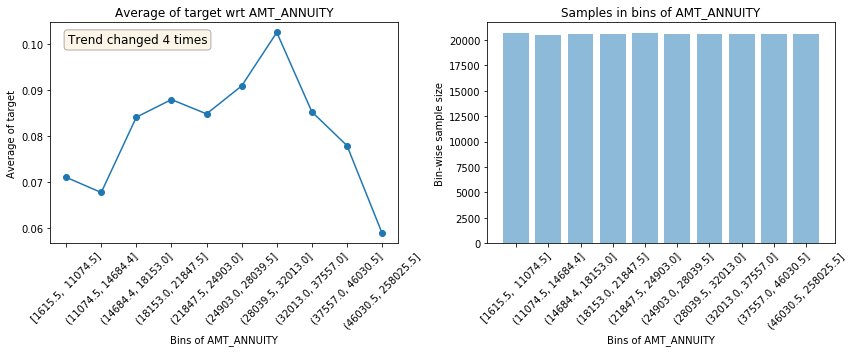

                                           Test data plots                                            


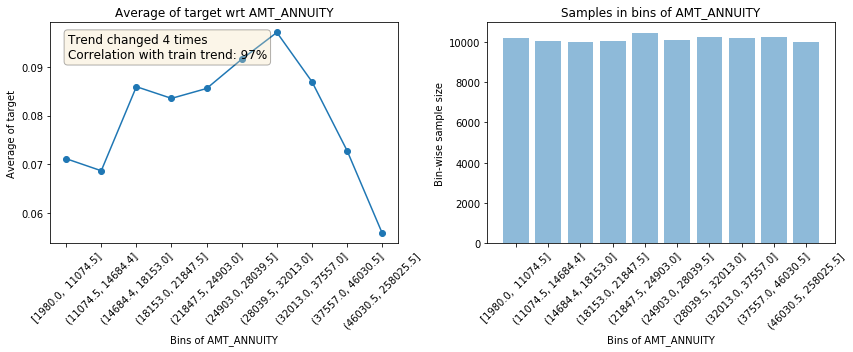

--------------------------------------------------------------------------------------------------------------


                                      Plots for AMT_GOODS_PRICE                                       
                                           Train data plots                                           


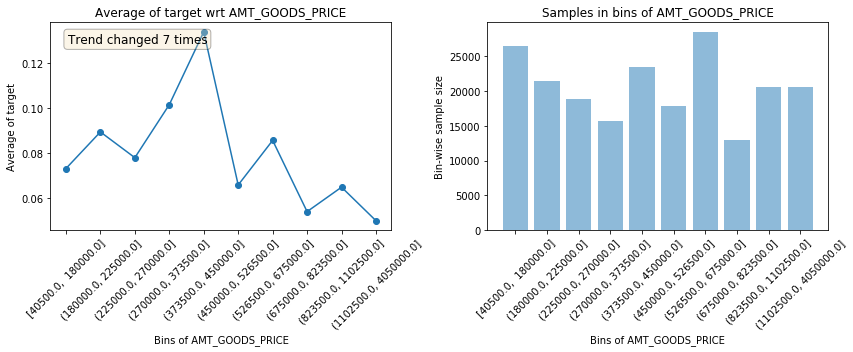

                                           Test data plots                                            


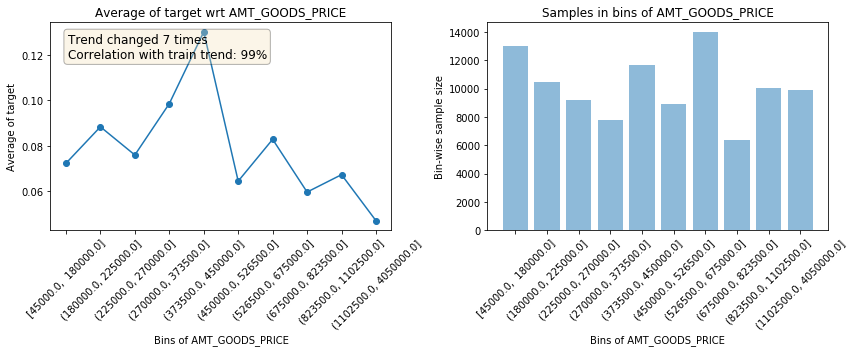

--------------------------------------------------------------------------------------------------------------


                                 Plots for REGION_POPULATION_RELATIVE                                 
                                           Train data plots                                           


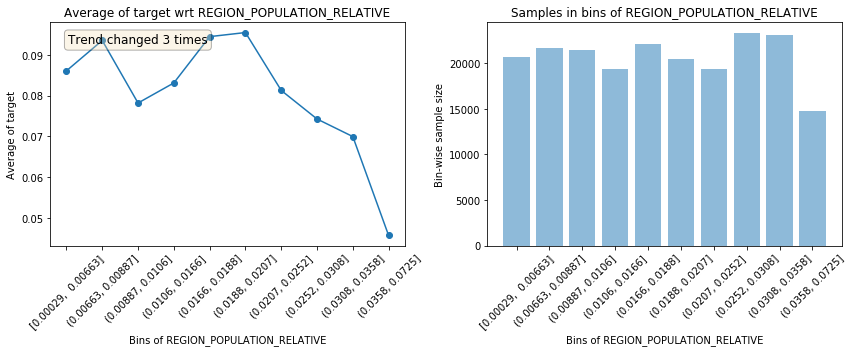

                                           Test data plots                                            


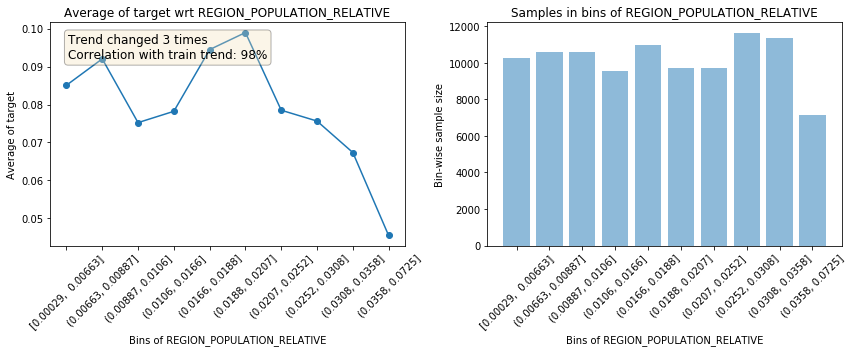

--------------------------------------------------------------------------------------------------------------


                                         Plots for DAYS_BIRTH                                         
                                           Train data plots                                           


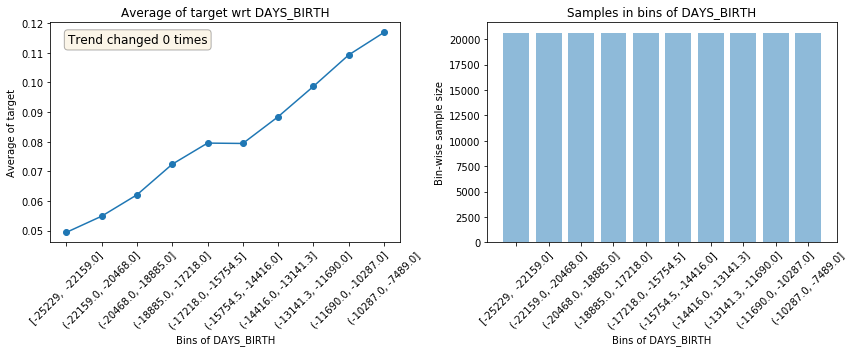

                                           Test data plots                                            


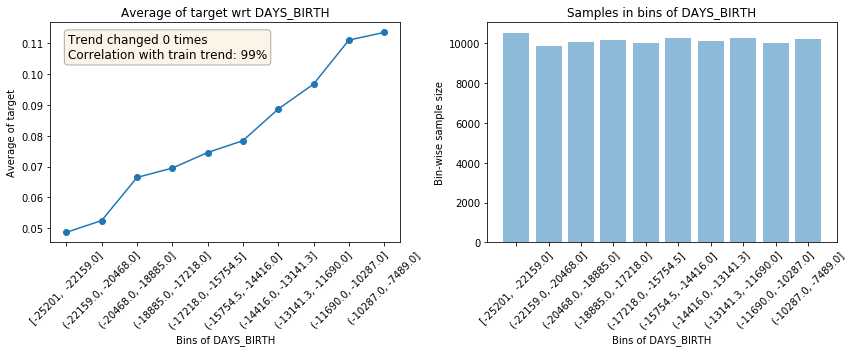

--------------------------------------------------------------------------------------------------------------


                                       Plots for DAYS_EMPLOYED                                        
                                           Train data plots                                           


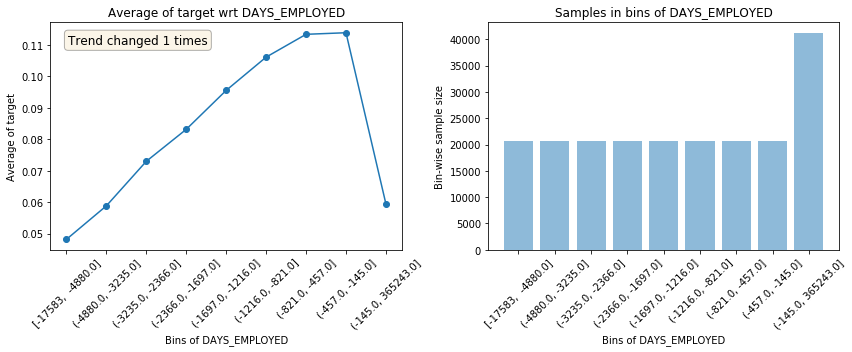

                                           Test data plots                                            


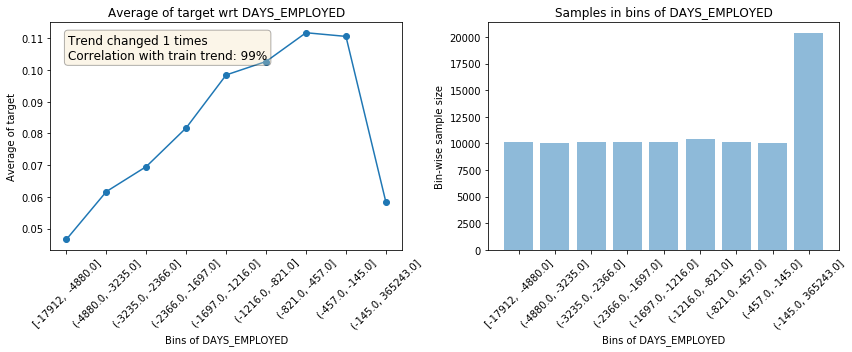

--------------------------------------------------------------------------------------------------------------


                                     Plots for DAYS_REGISTRATION                                      
                                           Train data plots                                           


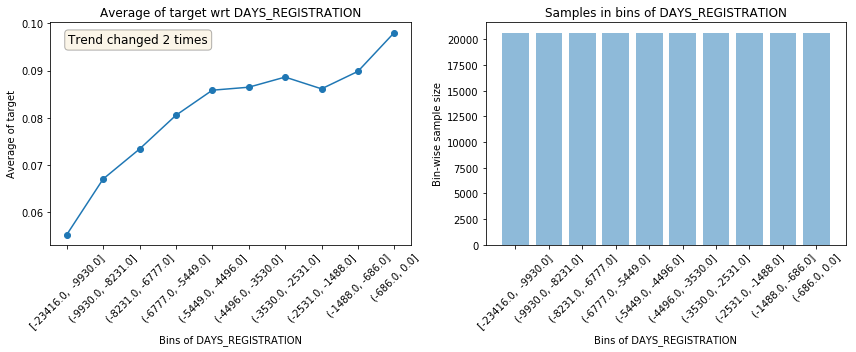

                                           Test data plots                                            


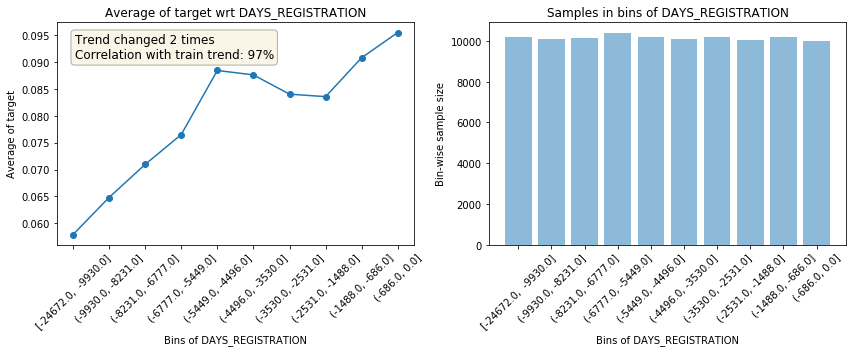

--------------------------------------------------------------------------------------------------------------


                                      Plots for DAYS_ID_PUBLISH                                       
                                           Train data plots                                           


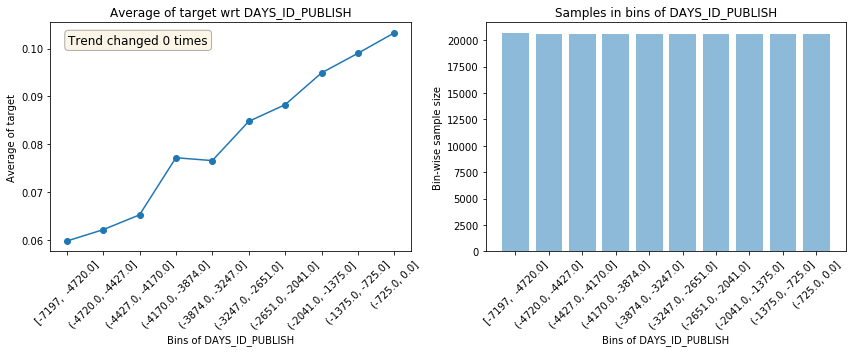

                                           Test data plots                                            


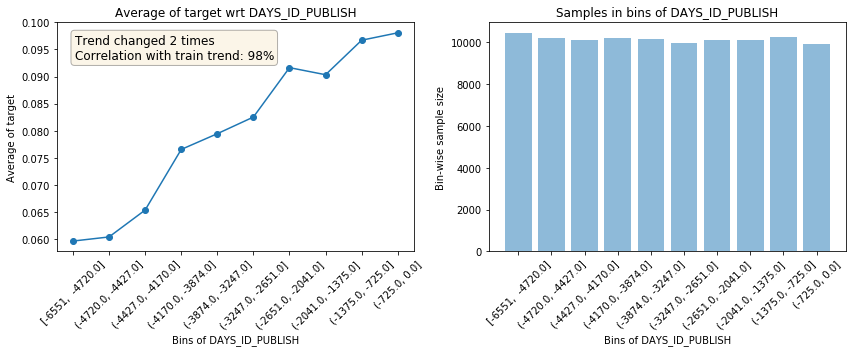

--------------------------------------------------------------------------------------------------------------




In [30]:
# plots univariate plots of first 10 columns in data_train
get_univariate_plots(data=data_train, target_col='target', features_list=data_train.columns[0:10], data_test=data_test)

                                      Plots for AMT_INCOME_TOTAL                                      
                                           Train data plots                                           


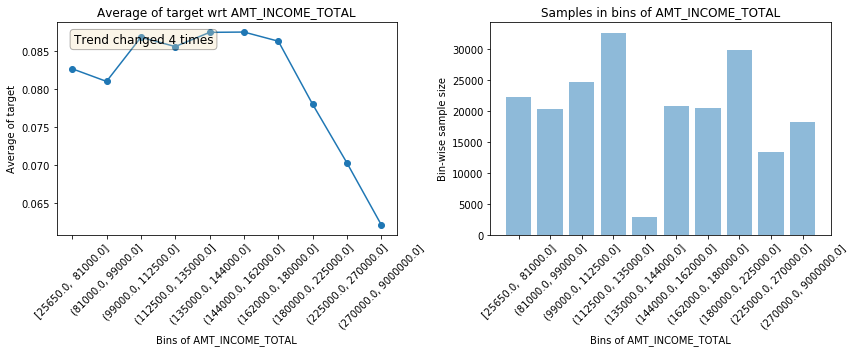

                                           Test data plots                                            


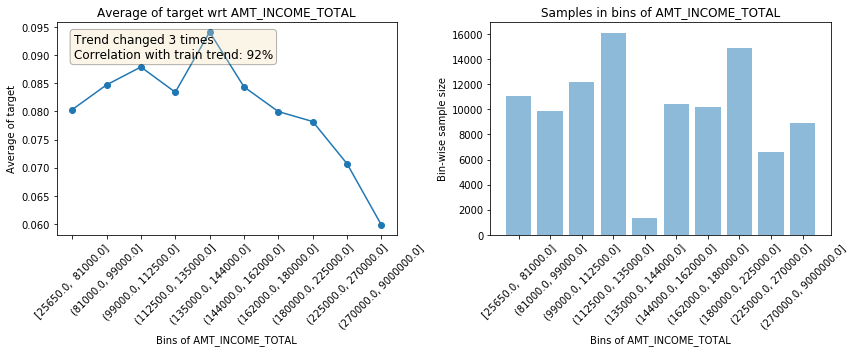

--------------------------------------------------------------------------------------------------------------




In [31]:
# Get grouped data, mean target and sample size of each group using univariate_plotter()
# With train and test data:
grouped_train, grouped_test = univariate_plotter(data=data_train, target_col='target', feature='AMT_INCOME_TOTAL',
                                                 data_test=data_test)

# With only train data
# grouped_train = univariate_plotter(data=data_train, target_col='target', feature='AMT_INCOME_TOTAL')

In [32]:
grouped_train #Grouped data showing bin level stats

AMT_INCOME_TOTAL  Samples_in_bin  target_mean  AMT_INCOME_TOTAL_mean
0    [25650.0,  81000.0]           22334     0.082699           66257.130366
1     (81000.0, 99000.0]           20424     0.081032           91076.626816
2    (99000.0, 112500.0]           24746     0.086842          111311.671092
3   (112500.0, 135000.0]           32725     0.085623          131844.069914
4   (135000.0, 144000.0]            2846     0.087491          142867.813598
5   (144000.0, 162000.0]           20804     0.087531          157082.746126
6   (162000.0, 180000.0]           20550     0.086326          178073.976044
7   (180000.0, 225000.0]           29937     0.077997          212795.095082
8   (225000.0, 270000.0]           13392     0.070266          259515.009845
9  (270000.0, 9000000.0]           18274     0.062110          389590.875377

In [33]:
dtrain = xgb.DMatrix(X_test, label=y_test, missing=np.nan)
dtest = xgb.DMatrix(X_train, label=y_train, missing=np.nan)

params = {'max_depth':8, 'learning_rate':0.1, 'silent':1, 'objective':'binary:logistic', 'min_child_weight':500,
            'eval_metric' : 'auc', 'nthread':8 } #col_sample_by_tree
xgb_model = xgb.train(params, dtrain, 400, evals=[(dtrain, 'train'), (dtest, 'test')], early_stopping_rounds=25) #, (dtest, 'test')

[0]	train-auc:0.719209	test-auc:0.707376
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[1]	train-auc:0.725595	test-auc:0.712347
[2]	train-auc:0.728705	test-auc:0.715003
[3]	train-auc:0.729957	test-auc:0.716409
[4]	train-auc:0.732076	test-auc:0.718048
[5]	train-auc:0.732548	test-auc:0.719023
[6]	train-auc:0.73384	test-auc:0.719887
[7]	train-auc:0.734324	test-auc:0.720007
[8]	train-auc:0.734282	test-auc:0.720243
[9]	train-auc:0.734843	test-auc:0.720743
[10]	train-auc:0.734984	test-auc:0.720509
[11]	train-auc:0.735792	test-auc:0.721211
[12]	train-auc:0.736458	test-auc:0.721955
[13]	train-auc:0.736459	test-auc:0.722084
[14]	train-auc:0.737083	test-auc:0.722724
[15]	train-auc:0.736761	test-auc:0.722505
[16]	train-auc:0.737258	test-auc:0.722843
[17]	train-auc:0.73727	test-auc:0.723086
[18]	train-auc:0.737828	test-auc:0.723617
[19]	train-auc:0.737898	test-auc:0.723894
[20]	train-auc:0.738789	test-au

[191]	train-auc:0.783366	test-auc:0.754944
[192]	train-auc:0.783486	test-auc:0.755027
[193]	train-auc:0.783612	test-auc:0.755061
[194]	train-auc:0.783711	test-auc:0.755042
[195]	train-auc:0.783827	test-auc:0.755055
[196]	train-auc:0.783909	test-auc:0.755046
[197]	train-auc:0.783984	test-auc:0.755039
[198]	train-auc:0.784105	test-auc:0.755128
[199]	train-auc:0.784191	test-auc:0.755162
[200]	train-auc:0.784293	test-auc:0.755173
[201]	train-auc:0.784429	test-auc:0.75523
[202]	train-auc:0.784468	test-auc:0.75525
[203]	train-auc:0.784569	test-auc:0.755253
[204]	train-auc:0.784656	test-auc:0.755271
[205]	train-auc:0.784747	test-auc:0.755272
[206]	train-auc:0.784861	test-auc:0.75525
[207]	train-auc:0.784968	test-auc:0.755231
[208]	train-auc:0.785084	test-auc:0.755218
[209]	train-auc:0.785168	test-auc:0.755234
[210]	train-auc:0.785259	test-auc:0.755306
[211]	train-auc:0.78537	test-auc:0.75527
[212]	train-auc:0.785416	test-auc:0.755271
[213]	train-auc:0.785487	test-auc:0.755251
[214]	train-auc:

In [34]:
dTEST = xgb.DMatrix(X_TEST[X_test.columns], missing=np.nan)
y_TEST_pred = xgb_model.predict(dTEST)
submission_all_feats = pd.DataFrame({'SK_ID_CURR' : TEST_users['SK_ID_CURR'], 'TARGET' : y_TEST_pred})
submission_all_feats.to_csv('submission_all_feats_1.csv', index=False)

In [35]:
stats = get_trend_stats(data=data_train, target_col='target', data_test=data_test)
# 0 correlation is returned for constant valued features and hence get dropped based on low correlation criteria

Only one bin created for FLAG_MOBIL. Correlation can't be calculated
Only one bin created for FLAG_CONT_MOBILE. Correlation can't be calculated
Only one bin created for NAME_CONTRACT_TYPE_Cash loans. Correlation can't be calculated
Only one bin created for NAME_CONTRACT_TYPE_nan. Correlation can't be calculated
Only one bin created for CODE_GENDER_nan. Correlation can't be calculated
Only one bin created for FLAG_OWN_CAR_nan. Correlation can't be calculated
Only one bin created for FLAG_OWN_REALTY_nan. Correlation can't be calculated
Only one bin created for NAME_INCOME_TYPE_nan. Correlation can't be calculated
Only one bin created for NAME_EDUCATION_TYPE_nan. Correlation can't be calculated
Only one bin created for NAME_FAMILY_STATUS_nan. Correlation can't be calculated
Only one bin created for NAME_HOUSING_TYPE_nan. Correlation can't be calculated
Only one bin created for WEEKDAY_APPR_PROCESS_START_nan. Correlation can't be calculated
Returning stats for all numeric features


In [37]:
def get_imp_df(xgb_model):
    imp = pd.DataFrame(np.asarray(list(xgb_model.get_fscore().keys())))
    imp.columns = ['Feature']
    imp['importance'] = np.asarray(list(xgb_model.get_fscore().values()))
    imp = imp.sort_values(by=['importance'], ascending=False)
    imp = imp.reset_index(drop=True)
    return (imp)

In [38]:
importance_df = get_imp_df(xgb_model) # get xgboost importances in dataframe
stats = pd.merge(stats, importance_df, how='left', on='Feature')
stats['importance'] = stats['importance'].fillna(0)

In [39]:
stats

Feature  Trend_changes  \
0                                CNT_CHILDREN              2   
1                            AMT_INCOME_TOTAL              4   
2                                  AMT_CREDIT              3   
3                                 AMT_ANNUITY              4   
4                             AMT_GOODS_PRICE              7   
5                  REGION_POPULATION_RELATIVE              3   
6                                  DAYS_BIRTH              0   
7                               DAYS_EMPLOYED              1   
8                           DAYS_REGISTRATION              2   
9                             DAYS_ID_PUBLISH              0   
10                                OWN_CAR_AGE              1   
11                                 FLAG_MOBIL              0   
12                             FLAG_EMP_PHONE              0   
13                            FLAG_WORK_PHONE              0   
14                           FLAG_CONT_MOBILE              0   
15                                 FLAG_PHONE              0   
16                                 FLAG_EMAIL              0   
17                            CNT_FAM_MEMBERS              1   
18                       REGION_RATING_CLIENT              0   
19                REGION_RATING_CLIENT_W_CITY              0   
20                    HOUR_APPR_PROCESS_START              2   
21                 REG_REGION_NOT_LIVE_REGION              0   
22                 REG_REGION_NOT_WORK_REGION              0   
23                LIVE_REGION_NOT_WORK_REGION              0   
24                     REG_CITY_NOT_LIVE_CITY              0   
25                     REG_CITY_NOT_WORK_CITY              0   
26                    LIVE_CITY_NOT_WORK_CITY              0   
27                               EXT_SOURCE_1              1   
28                               EXT_SOURCE_2              0   
29                               EXT_SOURCE_3              1   
..                                        ...            ...   
168      OCCUPATION_TYPE_Waiters/barmen staff              0   
169                       OCCUPATION_TYPE_nan              0   
170         WEEKDAY_APPR_PROCESS_START_FRIDAY              0   
171         WEEKDAY_APPR_PROCESS_START_MONDAY              0   
172       WEEKDAY_APPR_PROCESS_START_SATURDAY              0   
173         WEEKDAY_APPR_PROCESS_START_SUNDAY              0   
174       WEEKDAY_APPR_PROCESS_START_THURSDAY              0   
175        WEEKDAY_APPR_PROCESS_START_TUESDAY              0   
176      WEEKDAY_APPR_PROCESS_START_WEDNESDAY              0   
177            WEEKDAY_APPR_PROCESS_START_nan              0   
178          FONDKAPREMONT_MODE_not specified              0   
179       FONDKAPREMONT_MODE_org spec account              0   
180       FONDKAPREMONT_MODE_reg oper account              0   
181  FONDKAPREMONT_MODE_reg oper spec account              0   
182                    FONDKAPREMONT_MODE_nan              0   
183             HOUSETYPE_MODE_block of flats              0   
184           HOUSETYPE_MODE_specific housing              0   
185             HOUSETYPE_MODE_terraced house              0   
186                        HOUSETYPE_MODE_nan              0   
187                  WALLSMATERIAL_MODE_Block              0   
188                  WALLSMATERIAL_MODE_Mixed              0   
189             WALLSMATERIAL_MODE_Monolithic              0   
190                 WALLSMATERIAL_MODE_Others              0   
191                  WALLSMATERIAL_MODE_Panel              0   
192           WALLSMATERIAL_MODE_Stone, brick              0   
193                 WALLSMATERIAL_MODE_Wooden              0   
194                    WALLSMATERIAL_MODE_nan              0   
195                    EMERGENCYSTATE_MODE_No              0   
196                   EMERGENCYSTATE_MODE_Yes              0   
197                   EMERGENCYSTATE_MODE_nan              0   

     Trend_changes_test  Trend_correlation  importance  
0           

In [40]:
noisy = list(stats[stats['Trend_correlation']<0.95]['Feature'])
dtrain = xgb.DMatrix(X_test.drop(noisy, axis=1), label=y_test, missing=np.nan)
dtest = xgb.DMatrix(X_train.drop(noisy, axis=1), label=y_train, missing=np.nan)

params = {'max_depth':8, 'learning_rate':0.1, 'silent':0, 'objective':'binary:logistic', 'min_child_weight':500,
            'eval_metric' : 'auc', 'nthread':8 }
xgb_model = xgb.train(params, dtrain, 400, evals=[(dtrain, 'train'), (dtest, 'test')], early_stopping_rounds=25)

[0]	train-auc:0.719209	test-auc:0.707376
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[1]	train-auc:0.725595	test-auc:0.712347
[2]	train-auc:0.728705	test-auc:0.715003
[3]	train-auc:0.729957	test-auc:0.716409
[4]	train-auc:0.732076	test-auc:0.718048
[5]	train-auc:0.732548	test-auc:0.719023
[6]	train-auc:0.73384	test-auc:0.719887
[7]	train-auc:0.734309	test-auc:0.720001
[8]	train-auc:0.734273	test-auc:0.720245
[9]	train-auc:0.734822	test-auc:0.720797
[10]	train-auc:0.734964	test-auc:0.720552
[11]	train-auc:0.73578	test-auc:0.721248
[12]	train-auc:0.736445	test-auc:0.721993
[13]	train-auc:0.736453	test-auc:0.722118
[14]	train-auc:0.73707	test-auc:0.722744
[15]	train-auc:0.73675	test-auc:0.722525
[16]	train-auc:0.73724	test-auc:0.722857
[17]	train-auc:0.737358	test-auc:0.72316
[18]	train-auc:0.737902	test-auc:0.723698
[19]	train-auc:0.738192	test-auc:0.724149
[20]	train-auc:0.73869	test-auc:0.7

[191]	train-auc:0.781893	test-auc:0.754483
[192]	train-auc:0.781985	test-auc:0.754515
[193]	train-auc:0.782087	test-auc:0.754525
[194]	train-auc:0.782193	test-auc:0.754569
[195]	train-auc:0.78229	test-auc:0.754566
[196]	train-auc:0.782434	test-auc:0.75455
[197]	train-auc:0.782504	test-auc:0.754556
[198]	train-auc:0.78262	test-auc:0.7546
[199]	train-auc:0.782781	test-auc:0.754663
[200]	train-auc:0.782889	test-auc:0.754625
[201]	train-auc:0.782964	test-auc:0.754628
[202]	train-auc:0.783043	test-auc:0.754624
[203]	train-auc:0.783141	test-auc:0.754633
[204]	train-auc:0.783208	test-auc:0.754609
[205]	train-auc:0.783284	test-auc:0.754589
[206]	train-auc:0.783347	test-auc:0.754608
[207]	train-auc:0.783463	test-auc:0.754624
[208]	train-auc:0.783522	test-auc:0.754651
[209]	train-auc:0.783587	test-auc:0.754654
[210]	train-auc:0.783642	test-auc:0.754696
[211]	train-auc:0.783713	test-auc:0.754687
[212]	train-auc:0.783842	test-auc:0.754693
[213]	train-auc:0.783925	test-auc:0.75465
[214]	train-auc:0

In [41]:
dTEST = xgb.DMatrix(X_TEST[X_test.columns].drop(noisy, axis=1), missing=np.nan)
y_TEST_pred = xgb_model.predict(dTEST)
submission_95 = pd.DataFrame({'SK_ID_CURR' : TEST_users['SK_ID_CURR'], 'TARGET' : y_TEST_pred})
submission_95.to_csv('submission_95_1.csv', index=False)

In [42]:
noisy = list(stats[stats['Trend_correlation']<0.93]['Feature'])
dtrain = xgb.DMatrix(X_test.drop(noisy, axis=1), label=y_test, missing=np.nan)
dtest = xgb.DMatrix(X_train.drop(noisy, axis=1), label=y_train, missing=np.nan)

params = {'max_depth':8, 'learning_rate':0.1, 'silent':0, 'objective':'binary:logistic', 'min_child_weight':500,
            'eval_metric' : 'auc', 'nthread':8 }
xgb_model = xgb.train(params, dtrain, 400, evals=[(dtrain, 'train'), (dtest, 'test')], early_stopping_rounds=25)

[0]	train-auc:0.719209	test-auc:0.707376
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[1]	train-auc:0.725595	test-auc:0.712347
[2]	train-auc:0.728705	test-auc:0.715003
[3]	train-auc:0.729957	test-auc:0.716409
[4]	train-auc:0.732076	test-auc:0.718048
[5]	train-auc:0.732548	test-auc:0.719023
[6]	train-auc:0.73384	test-auc:0.719887
[7]	train-auc:0.734309	test-auc:0.720001
[8]	train-auc:0.734273	test-auc:0.720245
[9]	train-auc:0.734822	test-auc:0.720797
[10]	train-auc:0.734964	test-auc:0.720552
[11]	train-auc:0.73578	test-auc:0.721248
[12]	train-auc:0.736445	test-auc:0.721993
[13]	train-auc:0.736451	test-auc:0.722125
[14]	train-auc:0.737068	test-auc:0.722749
[15]	train-auc:0.736748	test-auc:0.722527
[16]	train-auc:0.73724	test-auc:0.722861
[17]	train-auc:0.737357	test-auc:0.723163
[18]	train-auc:0.737905	test-auc:0.723702
[19]	train-auc:0.738194	test-auc:0.724151
[20]	train-auc:0.73869	test-auc:

[191]	train-auc:0.782051	test-auc:0.754545
[192]	train-auc:0.782202	test-auc:0.754587
[193]	train-auc:0.782301	test-auc:0.754644
[194]	train-auc:0.782396	test-auc:0.754647
[195]	train-auc:0.782516	test-auc:0.754641
[196]	train-auc:0.782627	test-auc:0.754666
[197]	train-auc:0.782687	test-auc:0.754651
[198]	train-auc:0.782791	test-auc:0.754661
[199]	train-auc:0.782872	test-auc:0.754691
[200]	train-auc:0.782993	test-auc:0.75467
[201]	train-auc:0.783089	test-auc:0.754622
[202]	train-auc:0.783129	test-auc:0.754635
[203]	train-auc:0.783234	test-auc:0.754619
[204]	train-auc:0.783393	test-auc:0.754628
[205]	train-auc:0.783522	test-auc:0.754673
[206]	train-auc:0.783612	test-auc:0.754652
[207]	train-auc:0.783692	test-auc:0.754656
[208]	train-auc:0.783806	test-auc:0.754698
[209]	train-auc:0.783924	test-auc:0.754731
[210]	train-auc:0.783983	test-auc:0.754769
[211]	train-auc:0.784075	test-auc:0.754773
[212]	train-auc:0.784126	test-auc:0.754762
[213]	train-auc:0.784219	test-auc:0.754768
[214]	train-

In [43]:
dTEST = xgb.DMatrix(X_TEST[X_test.columns].drop(noisy, axis=1), missing=np.nan)
y_TEST_pred = xgb_model.predict(dTEST)
submission_93 = pd.DataFrame({'SK_ID_CURR' : TEST_users['SK_ID_CURR'], 'TARGET' : y_TEST_pred})
submission_93.to_csv('submission_93_1.csv', index=False)

In [44]:
noisy = list(stats[stats['Trend_correlation']<0.90]['Feature'])
dtrain = xgb.DMatrix(X_test.drop(noisy, axis=1), label=y_test, missing=np.nan)
dtest = xgb.DMatrix(X_train.drop(noisy, axis=1), label=y_train, missing=np.nan)

params = {'max_depth':8, 'learning_rate':0.1, 'silent':0, 'objective':'binary:logistic', 'min_child_weight':500,
            'eval_metric' : 'auc', 'nthread':8 }
xgb_model = xgb.train(params, dtrain, 400, evals=[(dtrain, 'train'), (dtest, 'test')], early_stopping_rounds=25)

[0]	train-auc:0.719209	test-auc:0.707376
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[1]	train-auc:0.725595	test-auc:0.712347
[2]	train-auc:0.728705	test-auc:0.715003
[3]	train-auc:0.729957	test-auc:0.716409
[4]	train-auc:0.732076	test-auc:0.718048
[5]	train-auc:0.732548	test-auc:0.719023
[6]	train-auc:0.73384	test-auc:0.719887
[7]	train-auc:0.734324	test-auc:0.720007
[8]	train-auc:0.734282	test-auc:0.720243
[9]	train-auc:0.734843	test-auc:0.720743
[10]	train-auc:0.734984	test-auc:0.720509
[11]	train-auc:0.735792	test-auc:0.721211
[12]	train-auc:0.736458	test-auc:0.721955
[13]	train-auc:0.736459	test-auc:0.722084
[14]	train-auc:0.737083	test-auc:0.722724
[15]	train-auc:0.736761	test-auc:0.722505
[16]	train-auc:0.737258	test-auc:0.722843
[17]	train-auc:0.73727	test-auc:0.723086
[18]	train-auc:0.737828	test-auc:0.723617
[19]	train-auc:0.737898	test-auc:0.723894
[20]	train-auc:0.738789	test-au

[191]	train-auc:0.783572	test-auc:0.754527
[192]	train-auc:0.783653	test-auc:0.754621
[193]	train-auc:0.783722	test-auc:0.754656
[194]	train-auc:0.783838	test-auc:0.754667
[195]	train-auc:0.783938	test-auc:0.754718
[196]	train-auc:0.784027	test-auc:0.754753
[197]	train-auc:0.784113	test-auc:0.75476
[198]	train-auc:0.784216	test-auc:0.754765
[199]	train-auc:0.784353	test-auc:0.754844
[200]	train-auc:0.784449	test-auc:0.754874
[201]	train-auc:0.784557	test-auc:0.754894
[202]	train-auc:0.784618	test-auc:0.754903
[203]	train-auc:0.784706	test-auc:0.754862
[204]	train-auc:0.784803	test-auc:0.754854
[205]	train-auc:0.784894	test-auc:0.754856
[206]	train-auc:0.784973	test-auc:0.75485
[207]	train-auc:0.785079	test-auc:0.754854
[208]	train-auc:0.785206	test-auc:0.754865
[209]	train-auc:0.785267	test-auc:0.754841
[210]	train-auc:0.78534	test-auc:0.754808
[211]	train-auc:0.785375	test-auc:0.754826
[212]	train-auc:0.785472	test-auc:0.754801
[213]	train-auc:0.785533	test-auc:0.75481
[214]	train-auc

In [45]:
dTEST = xgb.DMatrix(X_TEST[X_test.columns].drop(noisy, axis=1), missing=np.nan)
y_TEST_pred = xgb_model.predict(dTEST)
submission_90 = pd.DataFrame({'SK_ID_CURR' : TEST_users['SK_ID_CURR'], 'TARGET' : y_TEST_pred})
submission_90.to_csv('submission_90_1.csv', index=False)

In [46]:
noisy = list(stats[(stats['Trend_correlation']<0.95) & (stats['importance']<40)]['Feature'])
dtrain = xgb.DMatrix(X_test.drop(noisy, axis=1), label=y_test, missing=np.nan)
dtest = xgb.DMatrix(X_train.drop(noisy, axis=1), label=y_train, missing=np.nan)

params = {'max_depth':10, 'learning_rate':0.25, 'silent':0, 'objective':'binary:logistic', 'min_child_weight':500,
            'eval_metric' : 'auc', 'nthread':8 }
xgb_model = xgb.train(params, dtrain, 200, evals=[(dtrain, 'train'), (dtest, 'test')], early_stopping_rounds=25)

[0]	train-auc:0.719209	test-auc:0.707376
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[1]	train-auc:0.728127	test-auc:0.714669
[2]	train-auc:0.731963	test-auc:0.717814
[3]	train-auc:0.733352	test-auc:0.719019
[4]	train-auc:0.735104	test-auc:0.720794
[5]	train-auc:0.73508	test-auc:0.720846
[6]	train-auc:0.73636	test-auc:0.722293
[7]	train-auc:0.736858	test-auc:0.722799
[8]	train-auc:0.738297	test-auc:0.724796
[9]	train-auc:0.7394	test-auc:0.72616
[10]	train-auc:0.741093	test-auc:0.728213
[11]	train-auc:0.742778	test-auc:0.729462
[12]	train-auc:0.744664	test-auc:0.730616
[13]	train-auc:0.74594	test-auc:0.731742
[14]	train-auc:0.747865	test-auc:0.733718
[15]	train-auc:0.751025	test-auc:0.737001
[16]	train-auc:0.75264	test-auc:0.738004
[17]	train-auc:0.753905	test-auc:0.739145
[18]	train-auc:0.755102	test-auc:0.739914
[19]	train-auc:0.756681	test-auc:0.740985
[20]	train-auc:0.758087	test-auc:0.7

In [47]:
dTEST = xgb.DMatrix(X_TEST[X_test.columns].drop(noisy, axis=1), missing=np.nan)
y_TEST_pred = xgb_model.predict(dTEST)
submission_95_40 = pd.DataFrame({'SK_ID_CURR' : TEST_users['SK_ID_CURR'], 'TARGET' : y_TEST_pred})
submission_95_40.to_csv('submission_95_40_1.csv', index=False)